In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import random
import os

In [11]:
print(torch.cuda.is_available())

True


**Model Train** train-loss + val-loss + best model saving + learnning curve

Device: cuda
Epoch 1/70, Loss: 0.5084067336444197
Epoch 1/70, Validation Loss: 0.27503272518515587
!!!!Best is now!!!!
Epoch 2/70, Loss: 0.25918630330727016
Epoch 2/70, Validation Loss: 0.16443154960870743
!!!!Best is now!!!!
Epoch 3/70, Loss: 0.16405386477708817
Epoch 3/70, Validation Loss: 0.10012169927358627
!!!!Best is now!!!!
Epoch 4/70, Loss: 0.09784999078717725
Epoch 4/70, Validation Loss: 0.06250663008540869
!!!!Best is now!!!!
Epoch 5/70, Loss: 0.06246768850190886
Epoch 5/70, Validation Loss: 0.04185914667323232
!!!!Best is now!!!!
Epoch 6/70, Loss: 0.046109179612891425
Epoch 6/70, Validation Loss: 0.03322936734184623
!!!!Best is now!!!!
Epoch 7/70, Loss: 0.03915606721721847
Epoch 7/70, Validation Loss: 0.029152130940929055
!!!!Best is now!!!!
Epoch 8/70, Loss: 0.03554638089804814
Epoch 8/70, Validation Loss: 0.027774651302024722
!!!!Best is now!!!!
Epoch 9/70, Loss: 0.0347169903588706
Epoch 9/70, Validation Loss: 0.028137211687862873
Epoch 10/70, Loss: 0.03320197850979607
Epo

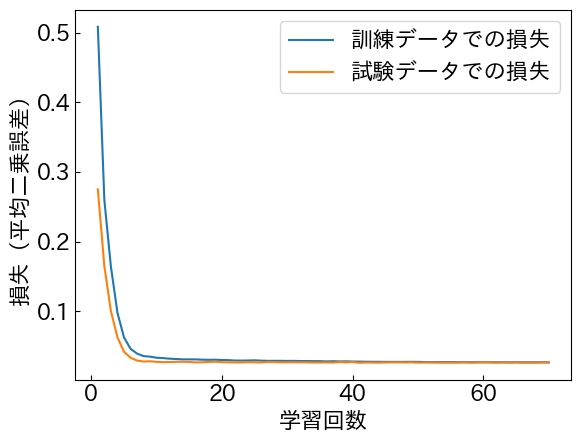

In [42]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import random
import os

# Transformerモデルの定義
class TransformerModel(nn.Module):
    def __init__(self, device):
        super(TransformerModel, self).__init__()
        self.device = device
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=12)
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8)
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=12)

    def forward(self, src, tgt):
        memory = self.encoder(src.to(self.device))
        output = self.decoder(tgt.to(self.device), memory)
        return output


# データの前処理と分割
def preprocess_data(data_file):
    data = np.load(data_file)
    # nanを含む行を削除
    data = data[~np.isnan(data).any(axis=(1, 2))]
    X = torch.tensor(data[:, 1, :], dtype=torch.float32)
    y = torch.tensor(data[:, 0, :], dtype=torch.float32)
    y = y.to(X.dtype)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    #X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    return X_train, y_train,X_test, y_test

# ハイパーパラメータの最適化（ランダムサーチ）
def optimize_hyperparameters(model):
    learning_rate = random.uniform(0.0001, 0.01)
    criterion = nn.MSELoss()
    #criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return learning_rate, criterion, optimizer

# 精度の計算
def calculate_accuracy(model, criterion, X_test, y_test):
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs, targets)
            loss = criterion(outputs, targets)
            running_loss += loss.item()

    avg_loss = running_loss / len(test_loader)
    return avg_loss

# 学習関数（チェックポイントと精度の保存先パスを指定）
def train_model(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs, batch_size, model_path):
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

    best_val_loss = float('inf')
    avg_losses = []
    val_losses = []
    for epoch in range(epochs):
        model.train().to(device)
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs, targets)
            #outputs = model(inputs.to(device), targets.to(device))
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # バッチごとに損失を計算
        avg_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss}")

        # テストデータで損失を計算
        val_loss = calculate_accuracy(model, criterion, X_test, y_test)
        print(f"Epoch {epoch+1}/{epochs}, Validation Loss: {val_loss}")

        avg_losses.append(avg_loss)
        val_losses.append(val_loss)

        # 精度が改善した場合はモデルを保存
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), os.path.join(model_path, "best_model.pt"))
            print("!!!!Best is now!!!!")

    # 学習曲線を保存
    np.save(os.path.join(model_path, "learning_curve.npy"), np.array([avg_losses, val_losses]))

    # 学習終了後、モデルを保存
    torch.save(model.state_dict(), os.path.join(model_path, "final_model.pt"))

    # 学習曲線を出力
    import matplotlib.pyplot as plt
    import japanize_matplotlib
    #from matplotlib.font_manager import FontProperties
    #matplotlib.font_manager.FontProperties(fname = フォント,size = フォントサイズ )
    plt.plot(range(1, epochs+1), avg_losses, label='訓練データでの損失')
    plt.plot(range(1, epochs+1), val_losses, label='試験データでの損失')
    plt.xlabel('学習回数')
    plt.ylabel('損失（平均二乗誤差）')
    plt.legend()
    plt.show()

# 学習データのファイルパス
data_file = "../Datasets/archive/reshaped_text_embeds.npy"
# モデルの保存先ディレクトリ
model_path = "../Models/CLAP_converter/Ray12_Att8/"

# ディレクトリが存在しない場合は作成
os.makedirs(model_path, exist_ok=True)

# CUDAが利用可能かチェック
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# モデルの初期化
model = TransformerModel(device)#.to(device)
if device == "cuda":
    model = model.cuda()

# データの前処理と分割
X_train, y_train, X_test, y_test = preprocess_data(data_file)

# ハイパーパラメータの最適化
learning_rate, criterion, optimizer = optimize_hyperparameters(model)

# モデルの学習
epochs = 70
batch_size = 128
train_model(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs, batch_size, model_path)

**Model Load Test**

In [2]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import os

# Transformerモデルの定義
class TransformerModel(nn.Module):
    def __init__(self):
        super(TransformerModel, self).__init__()
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8)
        self.encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=8)
        self.decoder_layer = nn.TransformerDecoderLayer(d_model=512, nhead=8)
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers=8)

    def forward(self, src, tgt):
        memory = self.encoder(src)
        output = self.decoder(tgt, memory)
        return output

# 学習後に保存されたモデルのパス
model_path = "../Models/CLAP_converter/best_model.pt"

# モデルの初期化
model = TransformerModel()
# GPUを利用可能であればGPUにモデルを転送
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)

# テスト用のランダムな(1,512)のテンソルを生成
random_input = torch.randn(1, 512).to(device)

# モデルにランダムな入力を与えてテスト
with torch.no_grad():
    model.eval()
    output = model(random_input, random_input)

# 出力を表示
print("Output tensor shape:", output.shape)
print("Sample of output tensor:", output)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Output tensor shape: torch.Size([1, 512])
Sample of output tensor: tensor([[-2.5444e-02,  9.7382e-03,  1.9677e-02, -4.7377e-02, -9.9439e-02,
          1.4063e-01,  1.1649e-02,  3.1281e-01,  1.2788e-01, -2.2899e-01,
         -1.7514e-02,  1.7825e-01, -1.9034e-02,  1.8481e-01,  1.0365e-02,
         -1.1961e-01, -4.7461e-01,  4.0005e-02, -1.1134e-01, -8.6782e-02,
         -8.9466e-02, -9.4809e-02, -2.3247e-01,  2.7140e-02, -1.8802e-01,
          1.3712e-01,  4.7812e-02, -8.4335e-02, -1.1310e-01,  1.9260e-01,
          3.9327e-02, -5.4515e-02, -6.4556e-02, -1.1702e-01, -7.7609e-02,
         -1.9888e-01,  1.2332e-01, -2.7026e-01, -5.2773e-02, -1.8656e-01,
         -2.6674e-01, -1.9884e-01,  8.4294e-02,  1.2006e-01, -2.0480e-01,
          3.9934e-01,  2.6074e-01, -5.4635e-02,  7.0548e-02, -1.2118e-01,
          3.5937e-02, -2.2366e-01, -1.6199e-01,  4.0294e-02,  5.7328e-02,
         -1.0200e-01, -1.8097e-01,  1.4614e-01,  1.8286e-01, -1.9161e-01,
          4.4930e-01, -1.2645e-01, -1.7887e-0

**CLIP+Converter vs CLAP**

In [3]:
import torch
import clip
import laion_clap
import numpy as np
import librosa

model1, preprocess1 = clip.load("ViT-B/32", device=device)
model2 = laion_clap.CLAP_Module(enable_fusion=False, amodel= 'HTSAT-base')
model2.load_ckpt('../Models/Laion_CLAP/music_audioset_epoch_15_esc_90.14.patched.pt')

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
model.safetensors: 100%|██████████████████████████████████████████████████████████████████████| 499M/499M [01:45<00:00, 4.74MB/s]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Load the specified checkpoint ../Models/Laion_CLAP/music_audioset_epoch_15_esc_90.14.patched.pt from users.
Load Checkpoint...
logit_scale_a 	 Loaded
logit_scale_t 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_real.weight 	 Loaded
audio_branch.spectrogram_extractor.stft.conv_imag.weight 	 Loaded
audio_branch.logmel_extractor.melW 	 Loaded
audio_branch.bn0.weight 	 Loaded
audio_branch.bn0.bias 	 Loaded
audio_branch.patch_embed.proj.weight 	 Loaded
audio_branch.patch_embed.proj.bias 	 Loaded
audio_branch.patch_embed.norm.weight 	 Loaded
audio_branch.patch_embed.norm.bias 	 Loaded
audio_branch.layers.0.blocks.0.norm1.weight 	 Loaded
audio_branch.layers.0.blocks.0.norm1.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.relative_position_bias_table 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.qkv.bias 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.weight 	 Loaded
audio_branch.layers.0.blocks.0.attn.proj.bias 	 Loaded
audio_b

In [5]:
text_data = "a cat"
with torch.no_grad():
    # model2.get_text_embeddingの前にtext_dataを配列に変換
    token = clip.tokenize(text_data).to(device)
    text_embed_clip = model1.encode_text(token)
    print(text_embed_clip.shape)
    print(text_embed_clip.dtype)
    text_embed_clip = text_embed_clip.to(torch.float32)
    print(text_embed_clip.dtype)

    # text_dataを2要素の配列に変換
    text_data_array = [text_data, ""]
    text_embed_clap = model2.get_text_embedding(text_data_array, use_tensor=True).to(device)
    # [2, 512]のTensorから第一要素を取り出し、[1, 512]のTensorにする
    text_embed_clap = text_embed_clap[0].unsqueeze(0)
    print(text_embed_clap.shape)
    print(text_embed_clap.dtype)

torch.Size([1, 512])
torch.float16
torch.float32
torch.Size([1, 512])
torch.float32


In [9]:
# モデルにランダムな入力を与えてテスト
with torch.no_grad():
    model.eval()
    output = model(text_embed_clap, text_embed_clap)

# 出力を表示
print("Output tensor shape:", output.shape)
print("Output tensor dtype:", output.dtype)
#print("Sample of output tensor:", output)
criterion = nn.MSELoss()
loss = criterion(output, text_embed_clip)
print(loss)

Output tensor shape: torch.Size([1, 512])
Output tensor dtype: torch.float32
tensor(0.0871, device='cuda:0')


**Learnig Curve plotter**

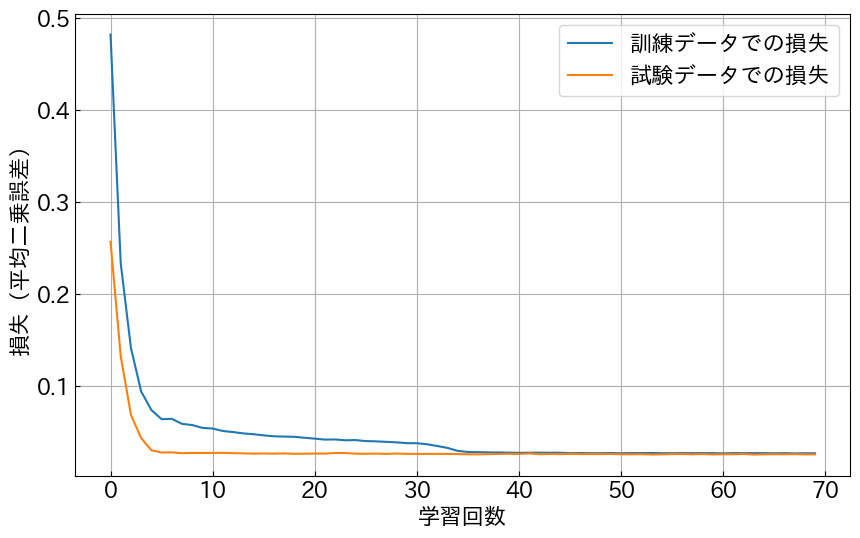

In [37]:
import os
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

# 学習曲線の保存先パス
model_path = "../Models/CLAP_converter/Ray12_Att8/"

# 学習曲線の読み込み
learning_curve = np.load(os.path.join(model_path, "learning_curve.npy"))

# 学習曲線の抽出
avg_losses, val_losses = learning_curve

# 学習曲線のプロット
plt.rcParams["font.size"] = 16
plt.figure(figsize=(10, 6))
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.plot(avg_losses, label='訓練データでの損失')#, color='blue')
plt.plot(val_losses, label='試験データでの損失')#, color='red')
#plt.title('Learning Curve')
plt.xlabel('学習回数')
plt.ylabel('損失（平均二乗誤差）')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(model_path, "learning_curve.eps"), format="eps")
plt.show()



In [23]:

torch.__version__

'2.1.1+cu121'

In [38]:
print(avg_losses)

[0.48235448 0.23375323 0.14166844 0.09444354 0.07426781 0.06428564
 0.06467322 0.05918384 0.05789899 0.05483589 0.05412774 0.05144668
 0.05026727 0.04883104 0.0479303  0.04669602 0.04566102 0.04537643
 0.04510546 0.04408185 0.04311538 0.04207964 0.04223968 0.04132873
 0.04157065 0.04047049 0.04017657 0.03965095 0.03909907 0.03821124
 0.03816023 0.03701184 0.03514471 0.03307213 0.02978077 0.02864125
 0.02844837 0.02818241 0.02811587 0.0278667  0.02768081 0.02783155
 0.02787764 0.02775464 0.02781211 0.02734614 0.02749098 0.02728712
 0.02729932 0.02747835 0.02722076 0.02744154 0.02742131 0.02753696
 0.02730223 0.0272478  0.02742279 0.02736101 0.02739536 0.02736181
 0.02713764 0.02742948 0.02734326 0.02737411 0.02739287 0.02719319
 0.02733611 0.02709251 0.02719411 0.02721426]
